In [1]:
import quandl
import pandas as pd
import quandl as q
import numpy as np
import matplotlib.pyplot as plt
quandl.ApiConfig.api_key = "-qMZRw2S5XascrrTLjF4"

In [2]:
#pega os dados da API
msft_data = q.get("EOD/MSFT", start_date="2010-01-01", end_date="2020-01-01")
msft_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.484005,27.761009,27.085812,27.596538,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.172375,27.241626,26.929997,27.003576,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.921340,27.215657,26.791495,27.038201,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.103124,27.172375,26.947309,26.966354,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.025909,27.518631,27.007904,27.401769,49628500.0


In [3]:
#retorno diário
# chama `Adj Close` para `daily_close`
daily_close = msft_data[['Adj_Close']]

# retorna a fracao
daily_return = daily_close.pct_change()

# replaca de NA por 0
daily_return.fillna(0, inplace=True)

#plt.plot(daily_return)

In [4]:
#media movel 7 dias
adj_price = msft_data['Adj_Close']
mav = adj_price.rolling(window=15).mean()

Date
2017-12-14    80.982311
2017-12-15    81.213647
2017-12-18    81.375389
2017-12-19    81.436606
2017-12-20    81.577083
2017-12-21    81.662786
2017-12-22    81.743335
2017-12-26    82.021711
2017-12-27    82.287199
2017-12-28    82.476650
Name: Adj_Close, dtype: float64


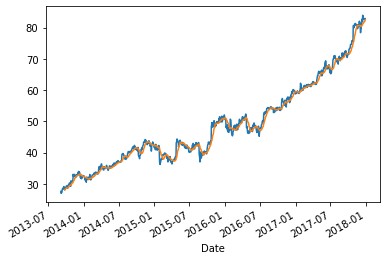

In [5]:
# print mav
print(mav[-10:])
adj_price.plot()
mav.plot()

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

#teste de estacionariedade
result = adfuller(daily_close.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.517888
p-value: 0.985407


In [7]:
## p >0.05, não é estacionária

In [8]:
df = pd.DataFrame(daily_close)

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(df.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1089
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1051.997
Method:                       css-mle   S.D. of innovations              0.636
Date:                Fri, 12 Jun 2020   AIC                           2111.995
Time:                        00:48:24   BIC                           2131.967
Sample:                             1   HQIC                          2119.554
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0503      0.013      3.948      0.000       0.025       0.075
ar.L1.D.y      0.9232      0.102      9.067      0.000       0.724       1.123
ma.L1.D.y     -0.9500      0.084    -11.249      0.0

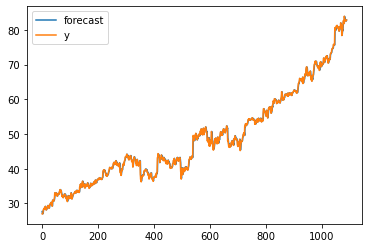

In [10]:
model_fit.plot_predict(dynamic=False)
plt.show()

c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


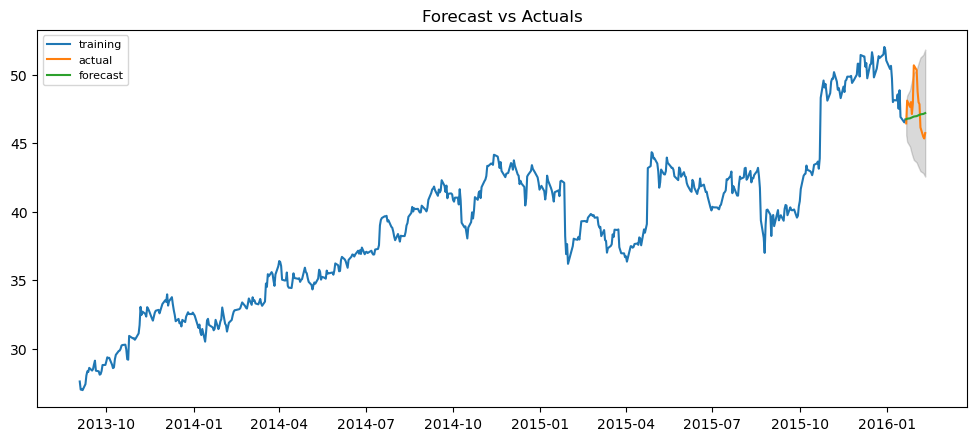

In [21]:
#vendo previsão
from statsmodels.tsa.stattools import acf
k = 600
# Cria treino e teste
train = df.Adj_Close[:k]
test = df.Adj_Close[k:k+15]

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Precisao
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Serie_panda
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [12]:
#melhor modelo arima

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2111.995, BIC=2131.967, Time=1.260 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2113.278, BIC=2123.264, Time=0.103 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2114.973, BIC=2129.952, Time=0.079 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2114.957, BIC=2129.936, Time=0.156 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2118.160, BIC=2123.153, Time=0.040 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=2113.895, BIC=2138.860, Time=2.049 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2113.898, BIC=2138.863, Time=1.150 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=2116.259, BIC=2136.231, Time=0.230 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=2116.323, BIC=2136.296, Time=0.202 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=2115.859, BIC=2145.817, Time=1.587 seconds
Total fit time: 6.884 seconds
      

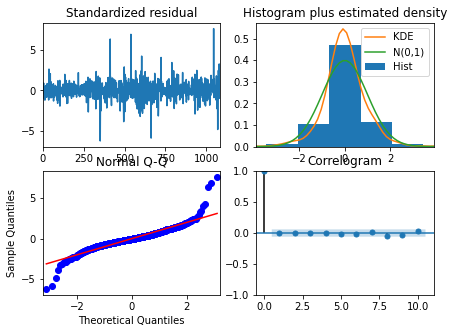

In [13]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [14]:
mav

Date
2013-09-03          NaN
2013-09-04          NaN
2013-09-05          NaN
2013-09-06          NaN
2013-09-09          NaN
                ...    
2017-12-21    81.662786
2017-12-22    81.743335
2017-12-26    82.021711
2017-12-27    82.287199
2017-12-28    82.476650
Name: Adj_Close, Length: 1090, dtype: float64

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=576.252, BIC=592.208, Time=0.275 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=573.518, BIC=581.496, Time=0.076 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=575.236, BIC=587.203, Time=0.058 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=575.217, BIC=587.184, Time=0.084 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=572.522, BIC=576.511, Time=0.026 seconds
Total fit time: 0.534 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -285.261
Date:                Fri, 12 Jun 2020   AIC                            572.522
Time:                        00:48:48   BIC                            576.511
Sample:                             0   HQIC                           574.102
  

c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


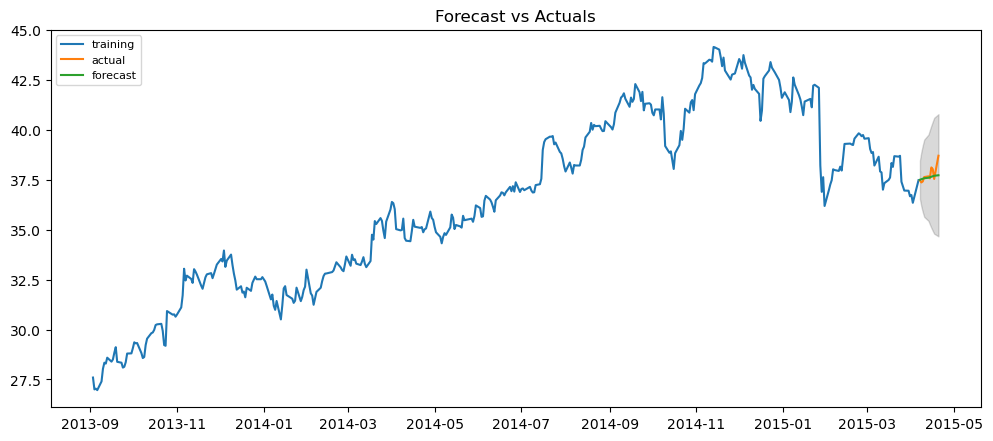

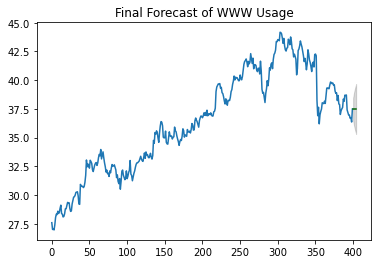

In [23]:
#vendo previsão
from statsmodels.tsa.stattools import acf
df = pd.DataFrame(daily_close)
daily_return = daily_close.pct_change()

# replaca de NA por 0
daily_return.fillna(0, inplace=True)

#df = daily_return

k = 400

# Cria treino e teste
train = df.Adj_Close[:k]
test = df.Adj_Close[k:k+10]

df_test = df.Adj_Close[:k+5]
df_pred = df.Adj_Close[:k]
#melhor modelo arima

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

model_to_fit = ARIMA(train, order=model.order) 
fitted = model_to_fit.fit(disp=-1)  
  
# Previsao
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Serie_panda
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


####################################################################
# ajeita pred
n_periods = 5
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_pred.values), len(df_pred.values)+n_periods)

# faz serie para proposito de predicaçõ
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_pred.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [17]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

ValueError: operands could not be broadcast together with shapes (5,) (10,) 

In [18]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=595.180, BIC=615.049, Time=0.894 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=1297.347, BIC=1305.295, Time=0.022 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=700.977, BIC=716.872, Time=0.382 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=979.996, BIC=995.892, Time=0.445 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=1302.331, BIC=1306.305, Time=0.019 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=817.661, BIC=833.557, Time=0.171 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=596.694, BIC=620.537, Time=0.959 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(1,0,1)x(0,1,2,7) [intercept=True]; AIC=596.760, BIC=620.603, Time=2.486 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 2, 7); setting score t

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  400
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 7)   Log Likelihood                -289.875
Date:                                Fri, 12 Jun 2020   AIC                            593.751
Time:                                        00:35:15   BIC                            621.567
Sample:                                             0   HQIC                           604.774
                                                - 400                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.007      0.160      0.873      -0.012       0.015
ar.L1          0.9969      0.018     56.104      0.000       0.962       1.032
ma.L1          0.0270      0.040      0.673      0.501      -0.052       0.106
ar.S.L7       -0.9932      0.050    -20.015      0.000      -1.090      -0.896
ma.S.L7       -0.0235     12.330     -0.002      0.998     -24.191      24.144
ma.S.L14      -0.9764     12.015     -0.081      0.935     -24.525      22.572
sigma2         0.2381      2.925      0.081      0.935      -5.494       5.970
===================================================================================
Ljung-Box (Q):                       46.44   Jarque-Bera (JB):              1541.99
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

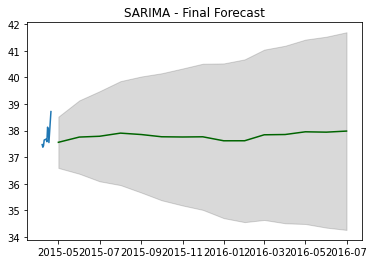

In [19]:
# Forecast
n_periods = 15
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(test)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()